In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

pathname = '/content/drive/MyDrive/Lies/'
data = pd.read_csv(pathname+'train.csv')

width, height = 48, 48

In [ ]:

datapoints = data['pixels'].tolist()

# getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

# getting labels for training
y = pd.get_dummies(data['emotion']).values

print(f"X.shape={X.shape}, y.shape={y.shape}")
# storing them using numpy
np.save(pathname+'fdataX', X)
np.save(pathname+'flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: " + str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")


X.shape=(28709, 48, 48, 1), y.shape=(28709, 7)
Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:28709
X,y stored in fdataX.npy and flabels.npy respectively


For later use

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def get_face_from_image(img):
  # resized_image = image_resize(img, width=1000)
  gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face.detectMultiScale(gray, 1.2, 5)
  return (True, faces[0]) if len(faces)>0 else (False, None)

#FER

## Train FER

In [ ]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf

In [ ]:

num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load(pathname+'fdataX.npy')
y = np.load(pathname+'flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

In [ ]:
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save(pathname+'modXtest', X_test)
np.save(pathname+'modytest', y_test)

#desinging the CNN
def create_model(n_hidden_conv_layers = 3):
  model = Sequential()

  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  for i in range(n_hidden_conv_layers):
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2**(i+1)*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) #0.4
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5)) #0.5

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [ ]:
model = create_model()
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
            metrics=['accuracy'])

In [ ]:
hist_cnn=model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open(pathname+"fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights(pathname+"fer.h5")
print("Saved model to disk")

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
history=hist_cnn

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'hist_cnn' is not defined

In [ ]:
xTrain = np.reshape(X_train, (X_train.shape[0], 48,48,1))
xValid = np.reshape(X_valid, (X_valid.shape[0], 48,48,1))
xTest = np.reshape(X_test, (X_test.shape[0], 48,48,1))
yTrain = np.argmax(y_train, axis=1)
yValid = np.argmax(y_valid, axis=1)
yTest = np.argmax(y_test, axis=1)

In [ ]:
y = y_train[2000]
indices_for_pos = np.squeeze(np.where(y_train == y))
indices_for_pos.shape
indices_for_pos

array([[    0,     0,     0, ..., 23253, 23253, 23253],
       [    0,     1,     3, ...,     2,     3,     5]])

In [ ]:
y_train.shape

(23254, 7)

In [ ]:
yTrain = np.argmax(y_train, axis=1)
yTrain[:10]

array([2, 6, 0, 3, 4, 2, 3, 6, 3, 2])

In [ ]:
np.squeeze(np.where(y_train == y))

array([[    0,     0,     0, ..., 23253, 23253, 23253],
       [    0,     1,     3, ...,     2,     3,     5]])

Loaded model from disk
Image Loaded
1/1 [==============================] - 0s 459ms/step
Emotion: Happy


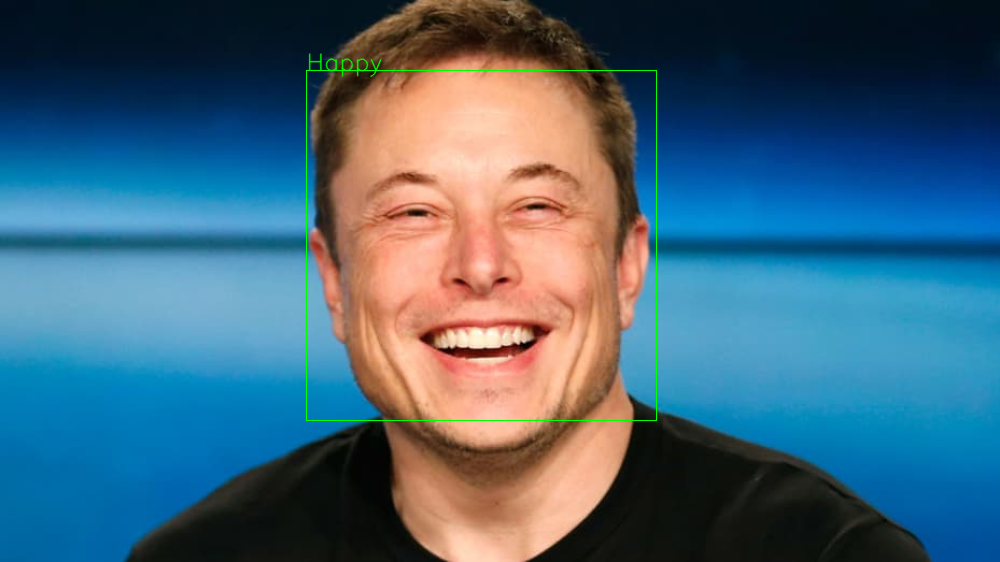

-1

In [ ]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#loading the model
json_file = open(pathname+'fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(pathname+"fer.h5")
print("Loaded model from disk")

#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
#test_path='/content/drive/MyDrive/deep-lie/fer2013/Test Images/'
full_size_image = cv2.imread('smile2.jpg') #pathname+"test.jpg"
full_size_image = image_resize(full_size_image, width=1000)
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face.detectMultiScale(gray, 1.3, 5)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[
            (np.argmax(yhat))])

cv2_imshow(full_size_image)
cv2.waitKey()


#Part 2 Lie Detection

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels = ['deceptive', 'truthful'], title='Confusion Matrix'):
  cm = confusion_matrix(y_true, y_pred)
  # labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  # title='Confusion matrix'
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()



## Preprocessing

In [ ]:
import pandas as pd

# define paths
video_path = "/content/drive/MyDrive/Lies/Videos/Real-life_Deception_Detection_2016/Truth+lie/"
whole_video_path = "/content/drive/MyDrive/Lies/Videos/Whole_Videos/"
project_path = "/content/drive/MyDrive/Lies/"

video_dir_path = "/content/drive/MyDrive/Lies/Videos/Real-life_Deception_Detection_2016/Annotation/Label.csv"


In [ ]:
video_data = pd.read_csv(video_dir_path)
print(video_data)


video_filenames = video_data['id'].tolist()
labels = [1 if x == 'truthful' else 0 for x in video_data['class'].tolist()]

# # storing them using numpy
# np.save(pathname+'fdataX', X)
# np.save(pathname+'flabels', y)

video_dict = dict(zip(video_filenames, labels))
print(video_dict)

                      id  OtherGestures  Smile  Laugh  Scowl  \
0      trial_lie_001.mp4              1      0      0      0   
1      trial_lie_002.mp4              1      0      0      0   
2      trial_lie_003.mp4              1      0      0      0   
3      trial_lie_004.mp4              1      0      0      0   
4      trial_lie_005.mp4              1      0      0      0   
..                   ...            ...    ...    ...    ...   
116  trial_truth_056.mp4              1      0      0      0   
117  trial_truth_057.mp4              1      0      0      0   
118  trial_truth_058.mp4              1      0      0      0   
119  trial_truth_059.mp4              0      0      0      1   
120  trial_truth_060.mp4              0      1      0      0   

     otherEyebrowMovement  Frown  Raise  OtherEyeMovements  Close-R  ...  \
0                       1      0      0                  1        0  ...   
1                       0      1      0                  1        0  ...   
2  

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow


def create_path(path):
  try:
    if not os.path.exists(path):
      os.makedirs(path)
  except OSError:
    print(f"Error: Creating directory: {path}")


# Given a filename, reads the video and captures frames from it
# For each frame, extracts a facial image if available
# Saves the cropped facial image
def read_video(filename, label):
  cam = cv2.VideoCapture(video_path+filename)
  currentframe = 0
  while(True):
    ret, frame = cam.read()
    if ret:
      name='./data/frame' + str(currentframe) + '.jpg'
      print('Showing...'+name)
      (detected, rect) = get_face_from_image(frame)
      print(f"frame.shape={frame.shape}")
      if detected:
        (x, y, w, h) = rect
        crop = frame[y:y+h, x:x+w]
        print(f"crop.shape={crop.shape}")
        cv2_imshow(crop)
        cv2.waitKey(0)
      currentframe+=1
    else:
      # print("End.")
      break
  # Release all space and windows once done
  cam.release()
  cv2.destroyAllWindows()


In [ ]:
create_path(whole_video_path)

from moviepy.editor import VideoFileClip, concatenate_videoclips

count=0
for (k, v) in video_dict.items():
  count+=1
  # if count >3: break
  print(k, v)
  # read_video(k, v)
  filenames = []
  for file in os.listdir(video_path):
    if file.startswith(k.replace('.mp4', '')):
        # clip = VideoFileClip(video_path+file)
        # print("file: ", file)
        # clips.append(clip)
        filenames.append(file)
  filenames.sort()
  clips = [VideoFileClip(video_path+x) for x in filenames]
  print(f"count: {count}::: filenames: {filenames}")
  if len(clips)>0:
      final_clip = concatenate_videoclips(clips)
      final_clip.write_videofile(whole_video_path+k)

trial_lie_001.mp4 0
count: 1::: filenames: ['trial_lie_001.mp4']
Moviepy - Building video /content/drive/MyDrive/Lies/Videos/Whole_Videos/trial_lie_001.mp4.
MoviePy - Writing audio in trial_lie_001TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Lies/Videos/Whole_Videos/trial_lie_001.mp4



t:  85%|████████▍ | 432/509 [00:08<00:01, 62.12it/s, now=None]

KeyboardInterrupt: 

In [ ]:
def preprocess_image(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # we turn the image to grayscale
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0)
  cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
  return cropped_img

# Given a filename, reads the video and captures frames from it
# For each frame, extracts a facial image if available
# Saves the cropped facial image
def read_video(filename, max_frames=300):
  cam = cv2.VideoCapture(whole_video_path+filename)
  currentframe = 0

  xdata = np.zeros((max_frames, 48*48))
  while(True):
    ret, frame_image = cam.read()

    if currentframe >= max_frames: break # limit the max number of frames we examine

    if ret: # a frame is found.
      # name='./data/frame' + str(currentframe) + '.jpg' # name of the image to store
      # print('Showing...'+name)

      # detect a primary face from the given frame image (if any)
      (detected, rect) = get_face_from_image(frame_image)
      # print(f"frame.shape={frame.shape}")

      # yhat = np.zeros((1, 7))

      x = np.zeros(48*48)
      # if a face is detected for the frame, crop the image
      if detected:
        (x, y, w, h) = rect
        cropped_face = frame_image[y:y+h, x:x+w]
        cropped_img = preprocess_image(cropped_face) # the low-res result ready for prediction
        # print(f'cropped_img shape={cropped_img.shape}')
        x = cropped_img.flatten()
        # print(f"x.shape: {x.shape}, min and max: {np.min(x), np.max(x)}")

        # make a prediction
        # yhat = loaded_model.predict(cropped_img)
      # print(f"yhat={yhat}")

      xdata[currentframe, :] = x
      # xdata[currentframe, :, :] = yhat

      currentframe+=1

    else: # we've reached the end of the video.
      break


  # Release all space and windows once done
  cam.release()
  cv2.destroyAllWindows()

  return xdata


def saveData(X, y):
  X = np.asarray(X)
  y = np.asarray(y)
  np.save(project_path+'fdataX', X)
  np.save(project_path+'flabels', y)
  print(f'Saving X and y of shape {X.shape}, {y.shape}, respectively.')


X = []
y = []

count = 0
for (k, v) in video_dict.items():
  count+=1
  print(k, v)
  xi = read_video(k)
  X.append(xi)
  y.append(v)
  if count % 5 == 0:
    saveData(X, y)



saveData(X, y)


trial_lie_001.mp4 0
trial_lie_002.mp4 0
trial_lie_003.mp4 0
trial_lie_004.mp4 0
trial_lie_005.mp4 0
Saving X and y of shape (5, 300, 2304), (5,), respectively.
trial_lie_006.mp4 0
trial_lie_007.mp4 0
trial_lie_008.mp4 0
trial_lie_009.mp4 0
trial_lie_010.mp4 0
Saving X and y of shape (10, 300, 2304), (10,), respectively.
trial_lie_011.mp4 0
trial_lie_012.mp4 0
trial_lie_013.mp4 0
trial_lie_014.mp4 0
trial_lie_015.mp4 0
Saving X and y of shape (15, 300, 2304), (15,), respectively.
trial_lie_016.mp4 0
trial_lie_017.mp4 0
trial_lie_018.mp4 0
trial_lie_019.mp4 0
trial_lie_020.mp4 0
Saving X and y of shape (20, 300, 2304), (20,), respectively.
trial_lie_021.mp4 0
trial_lie_022.mp4 0
trial_lie_023.mp4 0
trial_lie_024.mp4 0
trial_lie_025.mp4 0
Saving X and y of shape (25, 300, 2304), (25,), respectively.
trial_lie_026.mp4 0
trial_lie_027.mp4 0
trial_lie_028.mp4 0
trial_lie_029.mp4 0
trial_lie_030.mp4 0
Saving X and y of shape (30, 300, 2304), (30,), respectively.
trial_lie_031.mp4 0
trial_lie_

## Train DNN

In [ ]:
X = np.load(project_path+'fdataX.npy')
y = np.load(project_path+'flabels.npy')

print('Loaded data', X.shape, y.shape)

Loaded data (28709, 48, 48, 1) (28709, 7)


In [ ]:
X = np.reshape(X,(X.shape[0], X.shape[1], 48, 48))
X = np.expand_dims(X, -1)
X.shape

ValueError: cannot reshape array of size 66145536 into shape (28709,48,48,48)

GRU

In [ ]:
import sys, os
import pandas as pd
import numpy as np

from tensorflow.keras import initializers
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Masking, GRU
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# load the layers from the pre-trained, loaded model
layer_names = [layer.name for layer in loaded_model.layers]
layer_outputs = [layer.output for layer in loaded_model.layers]
print(f"layer_names total: {len(layer_names)}")

# pre-process input X
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

# for each entry, we will convert each of the 300 images (48, 48, 1) to encoding vectors
encoding_model = Model(inputs = loaded_model.inputs, outputs = layer_outputs[23])

X_cnn = np.zeros((X.shape[0], X.shape[1], 4608))
i = 0
for (xi, yi) in zip(X, y):
  # print(f"xi.shape={xi.shape}, yi.shape={yi.shape}, yi={yi}")
  predictedX = encoding_model.predict(xi)
  # the encoding vector for each facial image is a 336 dimensional vector,
  # and there are 300 frames.
  # print(f"predictedX has shape {predictedX.shape}")
  X_cnn[i] = predictedX
  i+=1


#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1, random_state=1) # random_state=42
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=7) # random_state=41

#saving the test samples to be used later
np.save(project_path+'modXtest', X_test)
np.save(project_path+'modytest', y_test)


layer_names total: 31
10/10 [==============================] - 0s 6ms/step


In [ ]:
print(X_train.shape, y_train.shape)
m = X_train.shape[0]
Tx = X_train.shape[1]
dims = X_train.shape[2]

(97, 300, 4608) (97,)


In [ ]:
# train a GRU network for binary classification
def create_gru_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  # X = MaxPooling1D(pool_size=15)(X)
  X = MaxPooling1D(pool_size=30, strides=15, padding='same')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.8)(X) #0.8 is fine!

  X = Dense(1, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model



gru_model = create_gru_model(input_shape=(Tx, dims))
gru_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 4608)]       0         
                                                                 
 conv1d (Conv1D)             (None, 72, 196)           13547716  
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 196)            0         
 D)                                                              
                                                                 
 batch_normalization_7 (Bat  (None, 5, 196)            784       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 5, 196)            0         
                                                                 
 dropout_7 (Dropout)         (None, 5, 196)            0   

In [ ]:
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, decay=0.01, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])

gru_model.fit(np.array(X_train), np.array(y_train),
          batch_size=64,
          epochs=150, #150
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)


# evaluate the keras model
_, accuracy = gru_model.evaluate(X_valid, y_valid)
acc_str = '%.2f' % (accuracy*100)
print(f'Accuracy: {acc_str}%')


#saving the  model to be used later
folder_path = "gru_model/"

gru_model_json = gru_model.to_json()
with open(project_path+folder_path+"gru_model_"+acc_str+".json", "w") as json_file:
    json_file.write(gru_model_json)
gru_model.save_weights(project_path+folder_path+"gru_model_"+acc_str+".h5")
print("Saved gru_model to disk")

NameError: name 'gru_model' is not defined

#Siamese Network with Triplet Loss for Classification

In [ ]:
# Data preprocessing
X_train = X_train.reshape(X_train.shape[0], 300, 4608)
print(X_train.shape, y_train.shape)
input_shape = X_train.shape[1:]
print(f"input_shape={input_shape}")

X_valid = X_valid.reshape(X_valid.shape[0], 300, 4608)

In [ ]:
import random

# Returns a list of randomly generated anchors, positives and negatives
# of size batch_size (default to 5000)
def create_batch(batch_size=5000):
    x_anchors = np.zeros((batch_size, 300, 4608))
    x_positives = np.zeros((batch_size, 300, 4608))
    x_negatives = np.zeros((batch_size, 300, 4608))

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, X_train.shape[0] - 1)
        x_anchor = X_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))

        x_positive = X_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = X_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]

        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

    return [x_anchors, x_positives, x_negatives]

In [ ]:
emb_size = 64

def create_embedding_model(input_shape):
  X_input = Input(shape=input_shape)
  X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) #filters = 196, kernel_size = 15
  # X = MaxPooling1D(pool_size=15)(X)
  X = MaxPooling1D(pool_size=30, strides=15, padding='valid')(X) # pool 30, strides 15 is fine!
  X = BatchNormalization()(X)
  X = Activation("relu")(X)
  X = Dropout(rate=0.8)(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = GRU(units=128, return_sequences=True)(X)
  X = Dropout(rate=0.8)(X)
  X = BatchNormalization()(X)

  X = Dropout(rate=0.5)(X) #0.8 is fine!

  X = Flatten()(X)
  X = Dense(emb_size, activation="sigmoid")(X)

  model = Model(inputs=X_input, outputs=X)

  return model

embedding_model=create_embedding_model(input_shape=(Tx, dims))
embedding_model.summary()

In [ ]:
# Siamese Network

input_anchor = Input(shape=(Tx, dims,))
input_positive = Input(shape=(Tx, dims,))
input_negative = Input(shape=(Tx, dims,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

# we will use this function to visualize how the embedding model is doing over time.
class PCAPlotter(tf.keras.callbacks.Callback):

    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()

        self.losses = []

    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()

    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

In [ ]:
# Triplet Loss

alpha = 0.2 # 0.6 was fine

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Data Generator

def data_generator(batch_size=64):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

# Model Training
batch_size = m
epochs = 100 #int(400000/m/100)
steps_per_epoch = int(m/batch_size)

net.compile(loss=triplet_loss, optimizer=Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=1e-7))


# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[
        early_stopping_callback,
        PCAPlotter(
            plt, embedding_model,
            X_valid[:1000], y_valid[:1000]
        )]
)

In [ ]:
# we need to store the average truth vector
# and the average lie vector learned
# with training set for verify
X_train_emb = embedding_model.predict(X_train)

truth_emb = []
lie_emb = []
for xi, yi in zip(X_train_emb, y_train):
  if yi == 1:
    truth_emb.append(xi)
  else:
    lie_emb.append(xi)
print(f"There are {len(truth_emb)} truths and {len(lie_emb)} lies.")

average_truth_emb = np.mean(truth_emb, axis=0)
average_lie_emb = np.mean(lie_emb, axis=0)

database={}
database['truth'] = average_truth_emb
database['lie'] = average_lie_emb

In [ ]:
# Validation Accuracy
X_valid_emb = embedding_model.predict(X_valid)
print(f"X_valid.shape={X_valid.shape}, X_valid_emb.shape={X_valid_emb.shape}, y_valid.shape={y_valid.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0
y_pred = []

for emb, y in zip(X_valid_emb, y_valid):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)


accuracy = count/X_valid_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Validation Accuracy: '+acc_str+'%')

In [ ]:
# Train accuracy
X_train_emb = embedding_model.predict(X_train)
print(f"X_train.shape={X_train.shape}, X_train_emb.shape={X_train_emb.shape}, y_train.shape={y_train.shape}")

# verify function: given an embedding, will tell whether or not it is truth
# based on distance from the average truth and the average lie vectors.
def verify(emb, embedding_model, database):
  dist_truth = np.linalg.norm(emb - database["truth"])
  dist_lie = np.linalg.norm(emb - database["lie"])
  print(f"dist_truth={dist_truth}, dist_lie={dist_lie}")
  return 1 if dist_truth < dist_lie  else 0


# now we measure the accuracy on validation set.
count = 0

y_pred = []
for emb, y in zip(X_train_emb, y_train):
  y_predict = verify(emb, embedding_model, database)
  y_pred.append(y_predict)
  # print("y_predict: ", y_predict, "y: ", y)
  if y_predict == y:
    count += 1
  else:
    print("y_predict: ", y_predict, "y: ", y)

accuracy = count/X_train_emb.shape[0]
acc_str = '%.2f' % (accuracy*100)
print('Train Accuracy: '+acc_str+'%')

In [ ]:
plot_confusion_matrix(np.array(y_train), np.array(y_pred), title='Confusion Matrix')